  
# Traffic gen. on fattree16
$$\quad$$



 


- [Section 1: Networking](#Networking)
- [Section 2: Traffic gen. of deepQueueNet](#Traffic_generalization)

 
 $$\quad$$


>   This notebook is to use the trained device model, deepQueueNet, to make end-to-end inference on fattree topology with different traffic patterns: 
>  - MAP
>  - Poisson
>  - OnOff
>
> The task is deployed on 4 gpus. 
 
 
 
<html>
<body> 
<div align="center">
<img src="./assets/deploy.png" alt="deplo"  width="500" height="230">
</div>
</body>
</html>

$$\quad$$ 
 $$\quad$$ 

In [2]:
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import pandas as pd 
import numpy as np 
# %load_ext autoreload     
# %autoreload 2
from code_deepQueueNet.config import BaseConfig, modelConfig
from code_deepQueueNet.util import inference
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline 

You have imported code_sigcomm_dqn.


# $\quad$
# $\quad$

## Networking
 
 ``Model Parameters``
> __traffic_pattern__:  ['onoff', 'poisson', 'map']  
> __file__: rsim (obtained via DES) and rsim_pred (obtained via inference) 

 
 
 

In [2]:
import warnings
warnings.filterwarnings("ignore")




traffic_pattern='map'
config=BaseConfig()
model_config=modelConfig()
for i in range(5):
    ins=inference.INFER('./data/fattree16/{}/rsim{}'.format(traffic_pattern, i+1), 
                         config, 
                         model_config)
    ins.run(gpu_number=4) #please set the value of gpu_number (1,2,4) accordingly. 

time used (total) 1.520425 min.
time used (total) 1.555098 min.
time used (total) 1.592502 min.
time used (total) 1.525970 min.
time used (total) 1.582774 min.


# $\quad$
# $\quad$

## Traffic_generalization
 

 Now, let's evaluate the traffic generalization of deepQueueNet on Fattree16.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:23<00:00,  7.91s/it]


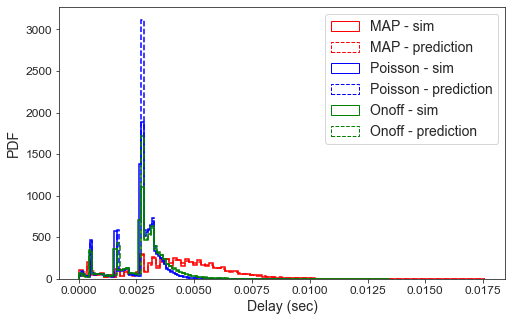

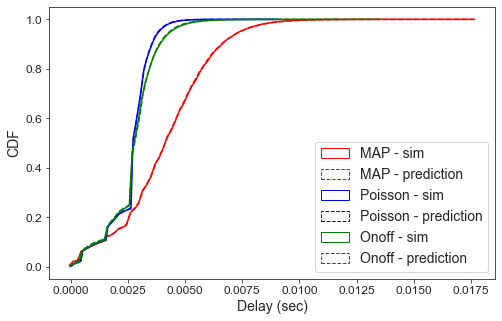

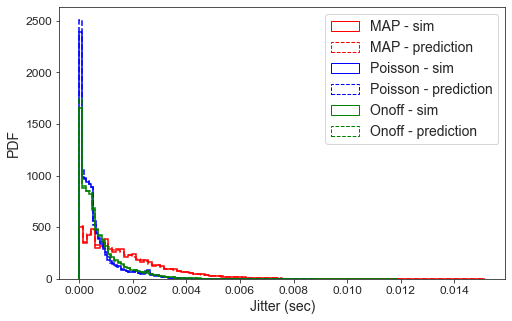

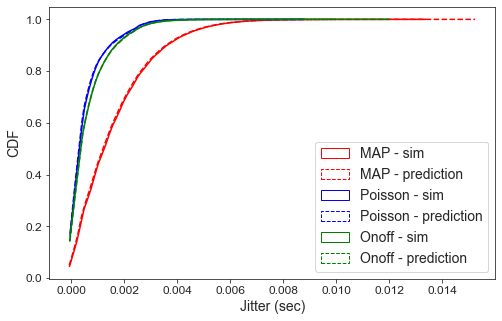

In [3]:
import tqdm
import matplotlib.patches as mpatches
import scipy.stats as measures


def showFig(df):
    for col in ['delay', 'jitter']:
        fig,(ax) = plt.subplots(figsize=(8,5))
        a_val = 1.
        colors = ['r','b','g']
        circ1 = mpatches.Patch(edgecolor=colors[0],alpha=a_val,linestyle ='-',label='MAP - sim', fill=False)
        circ2 = mpatches.Patch(edgecolor=colors[0],alpha=a_val,linestyle ='--',label='MAP - prediction',fill=False)
        circ3 = mpatches.Patch(edgecolor=colors[1],alpha=a_val,linestyle ='-',label='Poisson - sim', fill=False)
        circ4 = mpatches.Patch(edgecolor=colors[1],alpha=a_val,linestyle='--', label='Poisson - prediction', fill=False)
        circ5 = mpatches.Patch(edgecolor=colors[2],alpha=a_val,linestyle ='-',label='Onoff - sim', fill=False)
        circ6 = mpatches.Patch(edgecolor=colors[2],alpha=a_val,linestyle='--', label='Onoff - prediction', fill=False)
        
        
        for i, c in zip(['MAP','Poisson','Onoff'], colors):
            bins=np.histogram(np.hstack((df[df.tp==i][col+'_sim'].values, 
                                         df[df.tp==i][col+'_pred'].values)), bins=100)[1]  
            plt.hist(df[df.tp==i][col+'_sim'].values, bins, density=True, color=c, histtype='step',  linewidth=1.5);
            plt.hist(df[df.tp==i][col+'_pred'].values, bins, density=True, color=c, histtype='step', linestyle='--', linewidth=1.5);
        ax.legend(handles = [circ1,circ2,circ3,circ4,circ5,circ6],loc=1, fontsize = 14)
        plt.xlabel(col.capitalize()+' (sec)', fontsize = 14)
        plt.ylabel('PDF', fontsize = 14)
        plt.tick_params(labelsize=12)
        
        
        fig,(ax) = plt.subplots(figsize=(8,5))
        for i, c in zip(['MAP','Poisson','Onoff'], colors):
            res=stats.relfreq(df[df.tp==i][col+'_sim'].values, numbins=100)
            x=res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size, res.frequency.size)
            y=np.cumsum(res.frequency)
            plt.plot(x, y,color=c,  linewidth=1.5)
            res=stats.relfreq(df[df.tp==i][col+'_pred'].values, numbins=100)
            x=res.lowerlimit + np.linspace(0, res.binsize*res.frequency.size, res.frequency.size)
            y=np.cumsum(res.frequency)
            plt.plot(x, y,color=c, linestyle='--',   linewidth=1.5)
        plt.xlabel(col.capitalize()+' (sec)', fontsize = 14)
        plt.ylabel('CDF', fontsize = 14)
        ax.legend(handles = [circ1,circ2,circ3,circ4,circ5,circ6],loc=4, fontsize = 14)
        plt.tick_params(labelsize=12)
         
       
 
        
def mergeTrace():
    result=pd.DataFrame()
    for traffic_pattern in tqdm.tqdm(['onoff','poisson','map']):
        for filename in  ['rsim1', 'rsim2', 'rsim3', 'rsim4', 'rsim5']:
            t=pd.read_csv('./data/fattree16/{}/{}_pred.csv'.format(traffic_pattern, filename))
            t['delay_sim']=t['dep_time']-t['timestamp (sec)']
            t['delay_pred']=t['etime']-t['timestamp (sec)']
            t['fd']=t['path'].apply(lambda x: len(x.split('-'))) 
            t['jitter_sim']=t.groupby(['src_port', 'path'])['delay_sim'].diff().abs()
            t['jitter_pred']=t.groupby(['src_port', 'path'])['delay_pred'].diff().abs()
            if traffic_pattern=='map':
                t['tp']='MAP'
            else:
                t['tp']=traffic_pattern.capitalize()
            result=pd.concat([result, t], ignore_index=True)     
    return result 
             
    
result=mergeTrace()
showFig(result.dropna())

# $\quad$

# $\quad$